This project demonstrates a beginner-friendly approach to MNIST classification using an SVM classifier. The MNIST dataset consists of images in formats such as JPG, JPEG, and PNG, which I process using OpenCV to convert them into numerical data suitable for machine learning. At the end, I test the classifier using custom inputs that I drew in Paint, and the model performs well enough to meet my expectations, though I’m giving it some slack for a bit of room to improve.

## General imports

In [26]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Reading images workflow

In [2]:
folder_path = 'C:/Users/gurau/Desktop/Jupyter_Lab/3. Computer Vision/MNIST/mnist-png'

In [3]:
os.listdir(folder_path)

['MyTestBatch', 'test', 'train']

#### Function for reading images (from image format to numeric arrays of (size, size, channels))

In [4]:
def read_imgs(ds_type, folder_path):
    folder = os.path.join(folder_path, ds_type)
    images, labels = [], []
    
    for digit in os.listdir(folder):
        files_path = os.path.join(folder, digit)
        for image in os.listdir(files_path):
            image_path = os.path.join(files_path, image)
            images.append(cv2.imread(image_path))
            labels.append(int(digit))
            
    return images, labels

#### Dataset stored as numeric values, not shuffled

In [5]:
train_set = read_imgs('train', folder_path)
test_set = read_imgs('test', folder_path)

#### Function to make dataset in grayscale instead of BGR

In [6]:
def toGray(dataset):
    images, labels = dataset
    for i in range(len(images)):
        images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)

In [7]:
toGray(train_set)
toGray(test_set)

#### Function to flatten each image

In [8]:
test_set[0][0].reshape(-1).shape

(784,)

In [9]:
def flatten(dataset):
    images, labels = dataset
    for i in range(len(images)):
        images[i] = images[i].reshape(-1)        

In [10]:
flatten(train_set)
flatten(test_set)

#### Function to make DataFrame from dataset

In [11]:
def make_df(dataset):
    df = pd.DataFrame(dataset[0], columns= [f'pixel {i}' for i in range(1, 785)])
    df['label'] = dataset[1]
    return df

In [12]:
train_df = make_df(train_set)
test_df = make_df(test_set)

# ML workflow

In [13]:
X = train_df.drop(columns='label')
y = train_df['label'].copy()

from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC(probability=True))
])

In [15]:
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', SVC(probability=True))])

In [16]:
y_pred = model.predict(X_eval)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1181
           1       0.99      0.99      0.99      1350
           2       0.97      0.98      0.98      1162
           3       0.97      0.97      0.97      1203
           4       0.97      0.98      0.98      1124
           5       0.97      0.97      0.97      1116
           6       0.98      0.99      0.99      1221
           7       0.98      0.98      0.98      1249
           8       0.98      0.96      0.97      1210
           9       0.97      0.95      0.96      1184

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



### let's evaluate:

In [18]:
print(classification_report(test_df['label'], model.predict(test_df.drop(columns='label'))))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Not bad!

# Time to test it with my custom input

In [19]:
myTestBatch_ds = read_imgs('MyTestBatch', folder_path)
toGray(myTestBatch_ds)
flatten(myTestBatch_ds)

In [20]:
df = make_df(myTestBatch_ds)

X = df.drop(columns='label')
y = df['label']

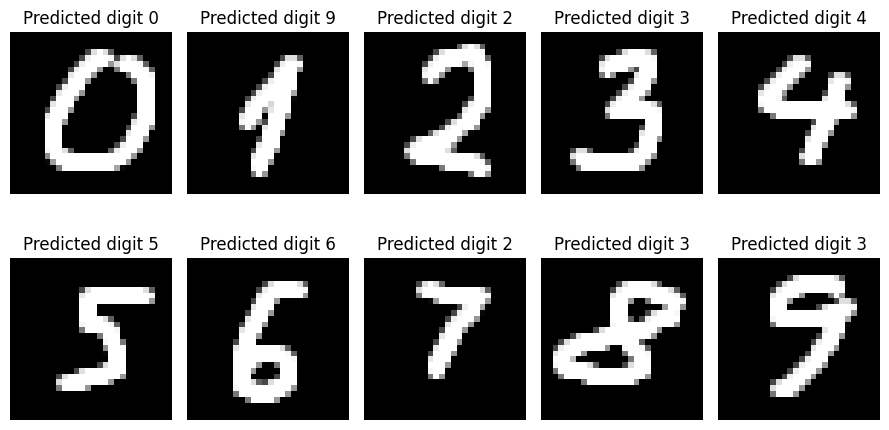

In [75]:
fig, axes = plt.subplots(2, 5, figsize=(9, 5))  
axes = axes.flatten()

pred = model.predict(X)

for i in range(10):
    axes[i].imshow(myTestBatch_ds[0][i].reshape(28, -1), cmap='gray')
    axes[i].set_title(f"Predicted digit {pred[i]}")
    axes[i].axis('off')

plt.tight_layout()

plt.show()

# ChatGPT code for better analysis

In [21]:
pred_probs = model.predict_proba(X)  # Get probability for each class

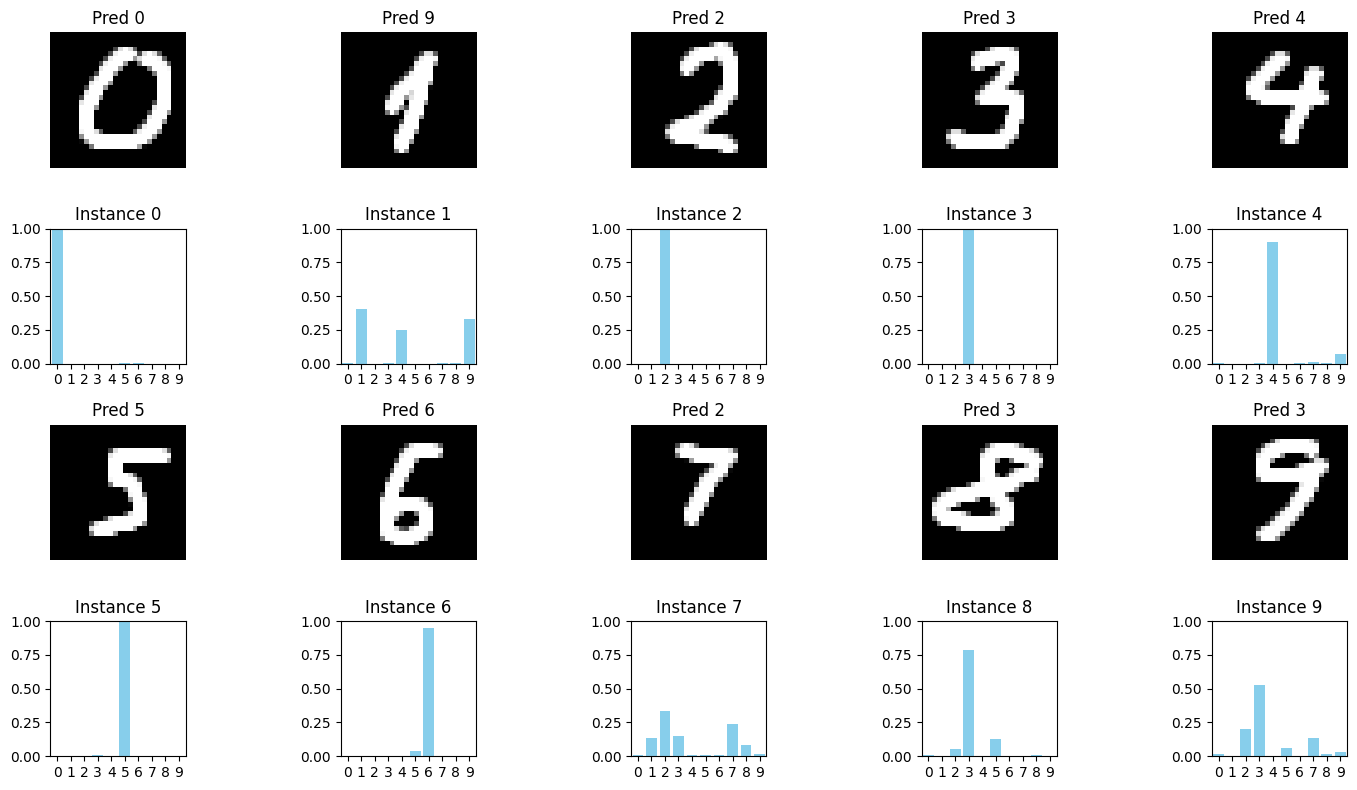

In [77]:
# 4 rows: image row, bar row, image row, bar row
fig, axes = plt.subplots(4, 5, figsize=(15, 8))  # Wider figure
axes = axes.reshape(4, 5)

# Predict using the model
pred = model.predict(X)
pred_probs = model.predict_proba(X)

for i in range(10):
    row_offset = 0 if i < 5 else 2  # Top half or bottom half
    col = i % 5

    # Image on top
    axes[row_offset][col].imshow(myTestBatch_ds[0][i].reshape(28, 28), cmap='gray')
    axes[row_offset][col].set_title(f"Pred {pred[i]}")
    axes[row_offset][col].axis('off')

    # Histogram below
    ax_bar = axes[row_offset + 1][col]
    ax_bar.bar(range(10), pred_probs[i], color='skyblue', width=0.8)
    ax_bar.set_xticks(range(10))
    ax_bar.set_xticklabels([str(j) for j in range(10)])
    ax_bar.set_ylim(0, 1)
    ax_bar.set_xlim(-0.5, 9.5)
    ax_bar.set_title(f'Instance {i}')
    ax_bar.set_aspect((10 / 1), adjustable='box')  # 1:1 look

plt.tight_layout()
plt.show()


This offers valuable insight!